# "Age Verification Using Computer Vision"

# Description:
In this project, I'm tasked with helping Good Seed, a supermarket chain, ensure they adhere to alcohol sales laws by preventing underage sales. Leveraging the cameras installed in checkout areas, I'll develop and evaluate a computer vision model capable of estimating a person's age from photographs taken during alcohol purchases. The goal is to create a reliable system that accurately verifies age, ensuring that alcohol is only sold to customers of legal age.

## Initialization

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(
dataframe=labels,
directory='/datasets/faces/final_files/',
x_col='file_name',
y_col='real_age',
target_size=(224, 224),
batch_size=32,
class_mode='raw',
seed=1234)

Found 7591 validated image filenames.


In [3]:
features, target = next(train_datagen_flow)

## EDA

In [4]:
print(labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


In [5]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [6]:
print(labels.sample(10))

       file_name  real_age
4990  004990.jpg        50
5306  005306.jpg        50
1513  001513.jpg        30
565   000565.jpg        16
6429  006433.jpg        25
4068  004068.jpg        24
1813  001813.jpg        50
650   000650.jpg        28
3115  003115.jpg         4
5417  005417.jpg        23


In [7]:
print(labels.duplicated().sum())

0


In [8]:
print(labels['real_age'].value_counts())

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64


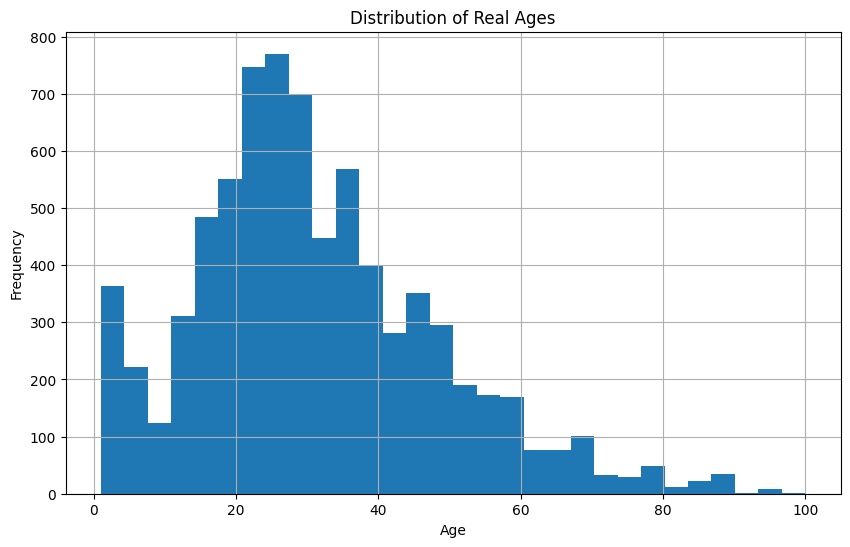

In [9]:
plt.figure(figsize=(10, 6))
labels['real_age'].hist(bins=30)
plt.title('Distribution of Real Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The frequency of ages is skewed to the right and the average is ~30

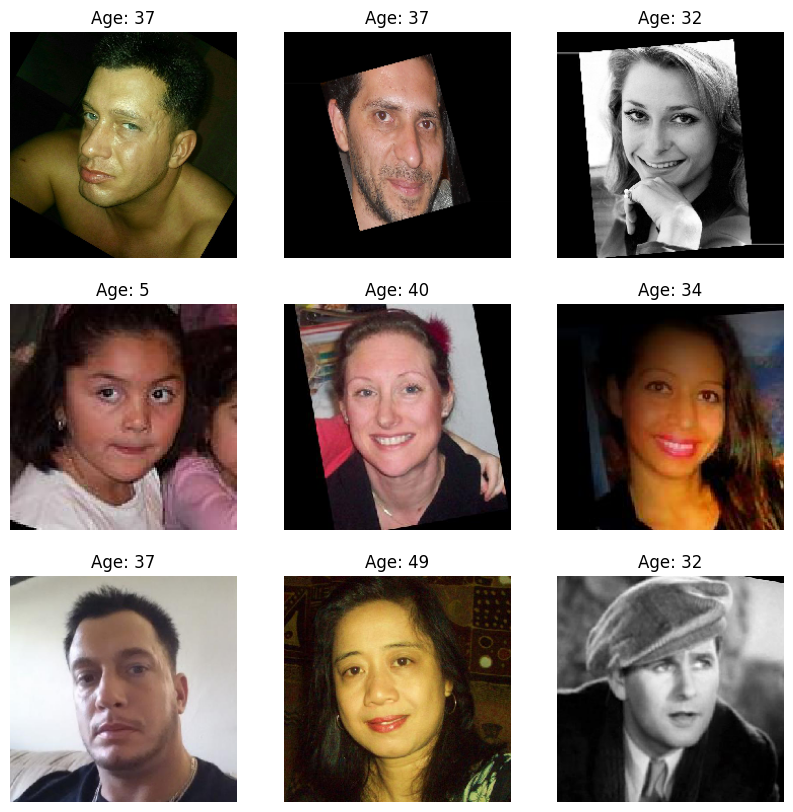

In [10]:
sample_files = random.sample(list(labels['file_name']), 9)

plt.figure(figsize=(10, 10))

for i, file in enumerate(sample_files):
    img = image.load_img(f'/datasets/faces/final_files/{file}', target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Age: {labels[labels['file_name'] == file]['real_age'].values[0]}")
    plt.axis('off')

plt.show()

### Findings

Age Distribution:

The average age of individuals in the images is 30 years.
The distribution of ages is positively skewed, which suggests that there are more younger individuals in the dataset. This could lead to potential challenges in accurately predicting the ages of older individuals. However, since the primary concern might be determining if someone is of legal drinking age (21 years), this skewness might not significantly impact the model's performance in this context.

Image Quality:

Some images in the dataset exhibit issues such as stretching along the edges, pixelation, tilting, or a combination of these distortions. These quality issues might affect the model's ability to accurately predict ages and may require preprocessing or data augmentation strategies to mitigate their impact.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [12]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    label = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255, horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=label,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(128, 128),
                                                batch_size=16,
                                                class_mode='raw',
                                                subset='training',
                                                seed=12345)

    return train_gen_flow

I agree that a vertical flip may not be necessary. While it could provide some variation in perspective, I decided to remove it in this case, especially because I needed to retrain the model due to my output mistake.

In [13]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=label,
                                               directory=path + 'final_files/',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(128, 128),
                                               batch_size=16,
                                               class_mode='raw',
                                               subset='validation',
                                               seed=12345)

    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    model=Sequential()
    
    optimizer=Adam(learning_rate=0.0001)
    
    backbone = ResNet50(include_top=False,
                        input_shape=input_shape,
                        weights='imagenet')
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        batch_size=batch_size,
        verbose=2
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [16]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Built with CUDA: True

Num GPUs Available:  1

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Epoch 1/10

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
  
355/355 - 106s - 300ms/step - loss: 234.1005 - mae: 11.2613 - val_loss: 379.2528 - val_mae: 14.4858

Epoch 2/10

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
  
355/355 - 2s - 6ms/step - loss: 110.0379 - mae: 9.1419 - val_loss: 471.7829 - val_mae: 16.9411

Epoch 3/10

355/355 - 25s - 69ms/step - loss: 99.2321 - mae: 7.5255 - val_loss: 275.0241 - val_mae: 12.5680

Epoch 4/10

355/355 - 0s - 249us/step - loss: 202.3232 - mae: 7.9135 - val_loss: 123.2279 - val_mae: 8.6973

Epoch 5/10

355/355 - 25s - 71ms/step - loss: 74.8717 - mae: 6.5291 - val_loss: 94.2288 - val_mae: 7.2695

Epoch 6/10

355/355 - 0s - 233us/step - loss: 38.5931 - mae: 4.7047 - val_loss: 83.0966 - val_mae: 7.2495

Epoch 7/10

355/355 - 24s - 68ms/step - loss: 51.9436 - mae: 5.4723 - val_loss: 89.2207 - val_mae: 7.3435

Epoch 8/10

355/355 - 0s - 251us/step - loss: 36.4934 - mae: 4.8953 - val_loss: 132.2298 - val_mae: 9.7739

Epoch 9/10

355/355 - 26s - 72ms/step - loss: 40.6500 - mae: 4.8587 - val_loss: 82.5201 - val_mae: 6.8377

Epoch 10/10

355/355 - 0s - 247us/step - loss: 22.2870 - mae: 3.8358 - val_loss: 60.0288 - val_mae: 6.1520

## Conclusions

### EDA Conclusion:

The analysis reveals that the most common age of shoppers falls between approximately 17 to 40 years, with a peak at 30 years. The dataset exhibits a positively skewed age distribution, suggesting that younger individuals are more prevalent, while there are relatively few shoppers over the age of 60. This skewness may pose challenges in accurately predicting the ages of older individuals, but since the focus is on determining whether someone is of legal drinking age (21 years), the impact may be minimal.

In terms of image quality, some photos in the dataset show distortions like stretching, pixelation, and tilting, which could hinder the model’s performance. Addressing these issues through preprocessing or data augmentation may be necessary to ensure more accurate age predictions.


### Model Conclusion:

A neural network model was successfully built using the ResNet50 architecture, achieving a mean absolute error (MAE) of 6.15 on the test set after 10 epochs. However, there is a slight gap between the MAE values of the training and test sets, which likely indicates some degree of overfitting that could be lessened with fewer augmentations.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training